# Prepare

In [7]:
from sklearn.model_selection import train_test_split

import pandas as pd
import sqlite3 
import os
import pandas_profiling
import seaborn as sns
import sqlite3 as sql
import hashlib

import pickle

In [2]:
# variables
INPUT_FOLDER = "input"
OUTPUT_FOLDER = "output"
DATA_FOLDER = "data"

db_name = "superstore.db"

#Pickle
temp_path = 'temp'
pckl_train = 'train_data'
pckl_test = 'test_data'


randon_state = 42

# Import

In [3]:
conn = sql.connect(os.path.join("..", DATA_FOLDER, db_name),
                   detect_types=sqlite3.PARSE_DECLTYPES | sqlite3.PARSE_COLNAMES)

In [4]:
stmt = "select * from superstore"

In [5]:
raw_df = pd.read_sql(stmt, conn, index_col='index')

# Train-Test-Split

In [8]:
df_train, df_test = train_test_split(raw_df, random_state = randon_state)

In [9]:
print("Train shape:", df_train.shape)
print("Test shape: ", df_test.shape)

Train shape: (38471, 23)
Test shape:  (12824, 23)


# Inspect

In [10]:
df_train.head()

,order_date,ship_date,ship_mode,customer_id,customer_name,segment,city,state,country,postal_code,...,category,sub-category,product_name,sales,quantity,discount,profit,shipping_cost,order_priority,returned
index,,,,,,,,,,,,,,,,,,,,,
27507,2012-12-27,2012-12-31,Standard Class,SP-20860,a7d03c30d416fc5f7d695b495884fdd7,Corporate,Murfreesboro,Tennessee,United States,37130.0,...,Technology,Accessories,SanDisk Ultra 16 GB MicroSDHC Class 10 Memory ...,72.744,7,0.2,-12.7302,6.720,Medium,No
35511,2014-12-25,2015-01-01,Standard Class,JD-15895,1b2850c124acd1bc24237b4b5228b65e,Corporate,Oosterhout,North Brabant,Netherlands,NaN,...,Office Supplies,Labels,"Smead File Folder Labels, Adjustable",23.730,7,0.5,-21.0000,3.430,Low,No
9172,2012-05-08,2012-05-11,Second Class,AB-10600,6acab08bb2b385c8569adfd24730ee01,Corporate,Phnom Penh,Phnom Penh,Cambodia,NaN,...,Furniture,Bookcases,"Dania Corner Shelving, Pine",617.100,5,0.0,172.6500,36.380,Medium,No
31366,2011-06-30,2011-07-02,Second Class,GH-14410,1528a0a296f3ecf500753855ea9a21a5,Home Office,Lima,Lima (city),Peru,NaN,...,Furniture,Chairs,"Hon Bag Chairs, Red",54.180,3,0.4,-32.5200,4.919,Medium,Yes
24465,2013-06-23,2013-06-26,First Class,KW-16435,648a7c6f93ee0f453ee1378466a84ff8,Consumer,London,England,United Kingdom,NaN,...,Office Supplies,Storage,"Fellowes Box, Wire Frame",50.625,3,0.1,20.2050,8.570,Medium,No


In [11]:
df_train.columns

Index(['order_date', 'ship_date', 'ship_mode', 'customer_id', 'customer_name',
       'segment', 'city', 'state', 'country', 'postal_code', 'market',
       'region', 'product_id', 'category', 'sub-category', 'product_name',
       'sales', 'quantity', 'discount', 'profit', 'shipping_cost',
       'order_priority', 'returned'],
      dtype='object')

In [12]:
type(df_train["order_date"][0])

pandas._libs.tslibs.timestamps.Timestamp

### Target Column

Time between order and shipment in days

In [13]:
df_train['ship_delay'] = df_train.apply(lambda x: (x["ship_date"]-x['order_date']).days, axis=1)

<ipython-input-13-3dd570fca43a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['ship_delay'] = df_train.apply(lambda x: (x["ship_date"]-x['order_date']).days, axis=1)


In [14]:
df_train[["order_date", "ship_date", "ship_delay"]].head()

,order_date,ship_date,ship_delay
index,,,
27507,2012-12-27,2012-12-31,4
35511,2014-12-25,2015-01-01,7
9172,2012-05-08,2012-05-11,3
31366,2011-06-30,2011-07-02,2
24465,2013-06-23,2013-06-26,3


---
It worked, so create the target column also for df_test (without sneaking inside)

In [15]:
df_train['ship_delay'] = df_train.apply(lambda x: (x["ship_date"]-x['order_date']).days, axis=1)

<ipython-input-15-3dd570fca43a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['ship_delay'] = df_train.apply(lambda x: (x["ship_date"]-x['order_date']).days, axis=1)


---

<AxesSubplot:>

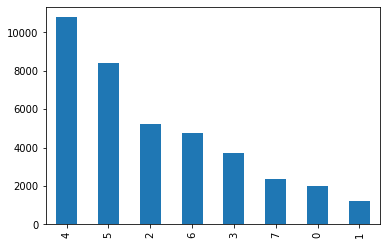

In [16]:
df_train["ship_delay"].value_counts().plot.bar()

### Profiling

In [ ]:
#profile = df_train.profile_report(title='Pandas Profiling Report')

In [ ]:
#os.makedirs(os.path.join('..',OUTPUT_FOLDER), exist_ok=True)
#profile.to_file(output_file=os.path.join("..", OUTPUT_FOLDER, "data_profile.html"))

### Missings

In [17]:
df_train.isnull().sum()

order_date            0
ship_date             0
ship_mode             0
customer_id           0
customer_name         0
segment               0
city                  0
state                 0
country               0
postal_code       30915
market                0
region                0
product_id            0
category              0
sub-category          0
product_name          0
sales                 0
quantity              0
discount              0
profit                0
shipping_cost         0
order_priority        0
returned              0
ship_delay            0
dtype: int64

Postal Code ==> useless

### Columnwise Inspection

#### Ship Date, Order Date

<AxesSubplot:xlabel='Count', ylabel='order_date'>

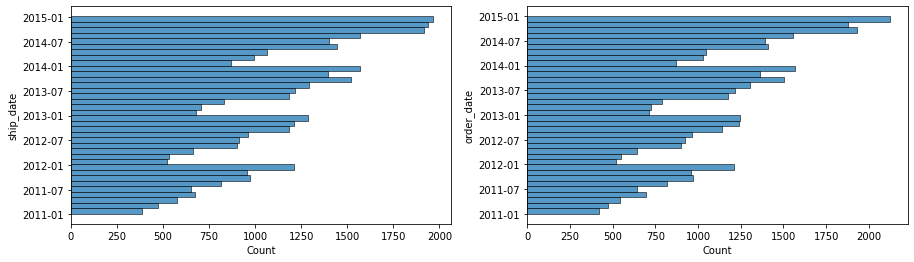

In [18]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [15, 4]
f, axes = plt.subplots(1, 2)

sns.histplot(data=df_train, y="ship_date", ax=axes[0])
sns.histplot(data=df_train, y="order_date", ax=axes[1])

#### Ship Mode

In [19]:
df_train["ship_mode"].value_counts()

Standard Class    23148
Second Class       7670
First Class        5588
Same Day           2065
Name: ship_mode, dtype: int64

* Predestined for OneHotEncoder

#### Customer ID, Customer Name

In [20]:
print("Unique values:", len(set(df_train["customer_id"])))
print("Total values:", len(df_train["customer_id"]))

Unique values: 1587
Total values: 38471


In [21]:
print("Unique values:", len(set(df_train["customer_name"])))
print("Total values:", len(df_train["customer_name"]))

Unique values: 795
Total values: 38471


* not useless at all... classification?

* customer may have nothing to do with the shipment delay (cannot be caused by the customer)

#### Segment

In [23]:
df_train["segment"].value_counts()

Consumer       20019
Corporate      11471
Home Office     6981
Name: segment, dtype: int64

=> OneHotEncoder

#### City, State, Country

In [24]:
print("Unique values City:", len(set(df_train["city"])))
print("Unique values State:", len(set(df_train["state"])))
print("Total values:", len(df_train["state"]))

Unique values City: 3475
Unique values State: 1072
Total values: 38471


In [25]:
df_train["country"].value_counts()

United States    7556
Australia        2137
France           2114
Mexico           2012
Germany          1570
                 ... 
Montenegro          2
South Sudan         1
Tajikistan          1
Burundi             1
Chad                1
Name: country, Length: 147, dtype: int64

=> Too high cardinality

#### Postal Code

useless due to missing values

#### Market

<AxesSubplot:ylabel='market'>

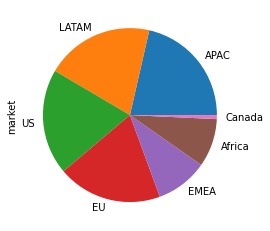

In [26]:
df_train["market"].value_counts().plot.pie()

* looks interesting, OneHotEncoder; there may be differences in the regions

#### Region

<AxesSubplot:ylabel='region'>

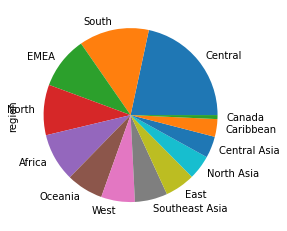

In [27]:
df_train["region"].value_counts().plot.pie()

* almost the same as market, but more detailed

#### Product ID, Product Name

In [28]:
df_train["product_id"]

index
27507    TEC-AC-10004227
35511    OFF-LA-10003699
9172     FUR-BO-10000112
31366    FUR-CH-10004338
24465    OFF-ST-10001646
              ...       
11284    FUR-BO-10001483
44732    OFF-LA-10002015
38158    OFF-LA-10004894
860      TEC-CO-10002009
15795    OFF-PA-10002725
Name: product_id, Length: 38471, dtype: object

In [29]:
df_train["product_name"]

index
27507    SanDisk Ultra 16 GB MicroSDHC Class 10 Memory ...
35511                 Smead File Folder Labels, Adjustable
9172                           Dania Corner Shelving, Pine
31366                                  Hon Bag Chairs, Red
24465                             Fellowes Box, Wire Frame
                               ...                        
11284                          Bush Corner Shelving, Metal
44732                       Hon Round Labels, Alphabetical
38158                    Hon Shipping Labels, Alphabetical
860                       Brother Wireless Fax, High-Speed
15795                     Eaton Cards & Envelopes, Premium
Name: product_name, Length: 38471, dtype: object

* Obviously too detailed

#### Category, Sub-Category

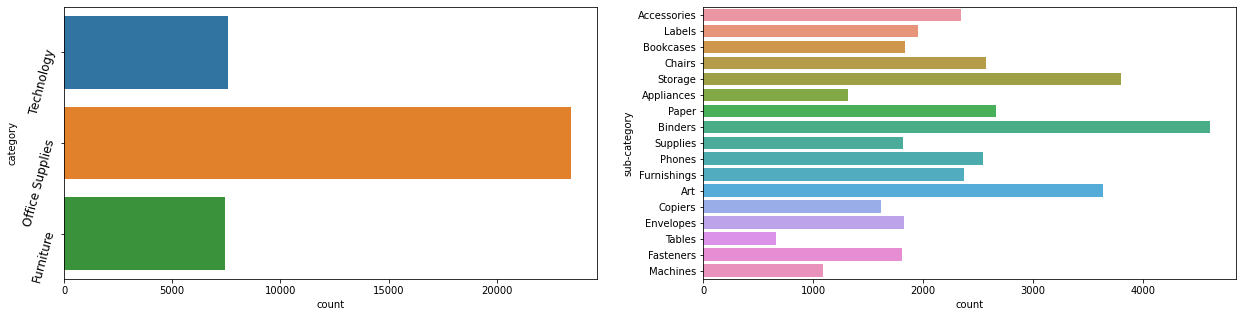

In [30]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [21, 5]

f, axes = plt.subplots(1, 2)

sns.countplot(data=df_train, y="category", ax=axes[0])
sns.countplot(data=df_train, y="sub-category", ax=axes[1])

axes[0].tick_params(axis='y', rotation=75, labelsize=12)

* OneHotEncoder

#### Sales, Discount, Profit

<AxesSubplot:xlabel='sales', ylabel='Count'>

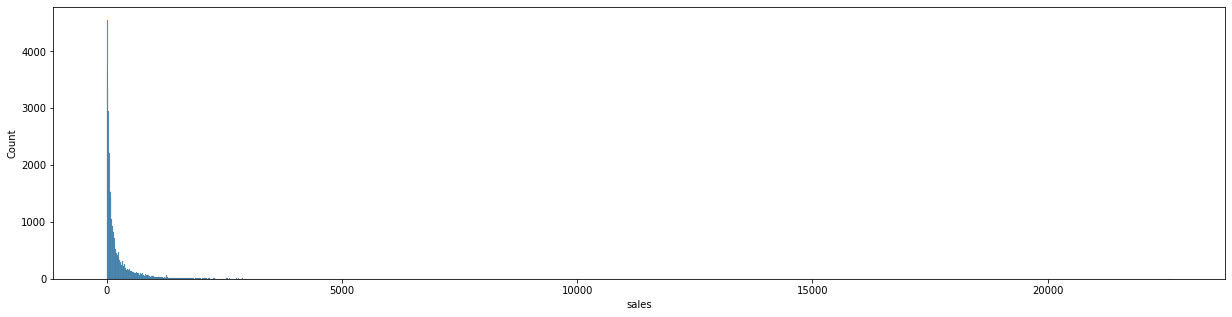

In [31]:
sns.histplot(data=df_train, x="sales")

<AxesSubplot:xlabel='sales', ylabel='Count'>

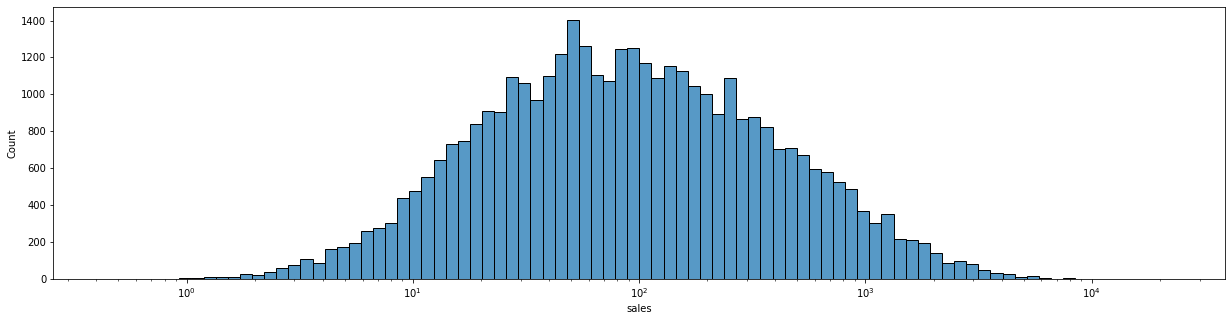

In [32]:
sns.histplot(data=df_train, x="sales", log_scale=True)

* Log-normal distribution ?

In [33]:
df_train["profit"].min()

-4088.3759999999997

In [34]:
df_train["profit"].max()

8399.975999999999

[None]

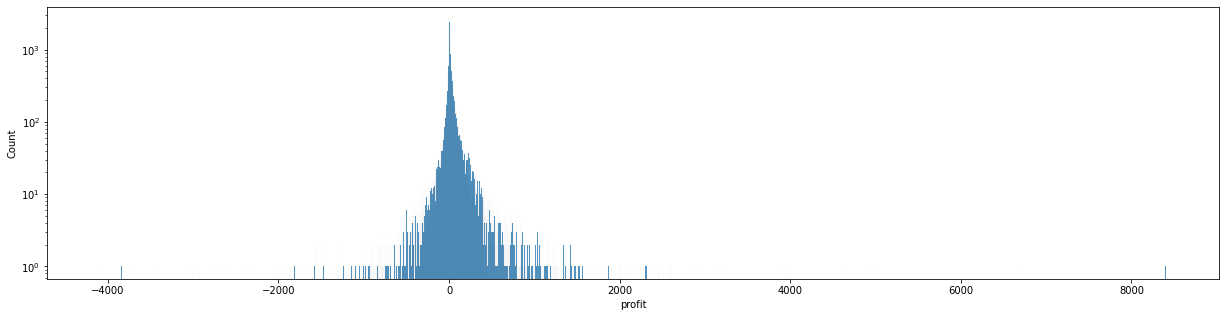

In [35]:
sns.histplot(df_train["profit"]).set(yscale="log")

#### Quantity

In [36]:
df_train["quantity"].value_counts()

2     9598
3     7260
1     6706
4     4797
5     3652
6     2243
7     1806
8     1013
9      738
10     198
14     147
12     130
11     121
13      62
Name: quantity, dtype: int64

#### Discount

<AxesSubplot:>

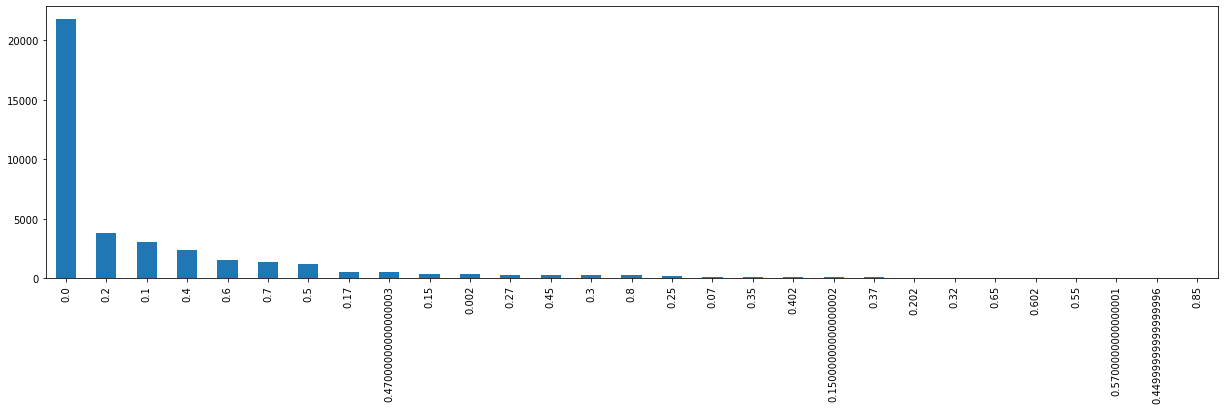

In [37]:
df_train["discount"].value_counts().plot.bar()

* Percentage, already normalized
* Discount = lower order priority?

#### Shipping Cost

<AxesSubplot:xlabel='shipping_cost', ylabel='Count'>

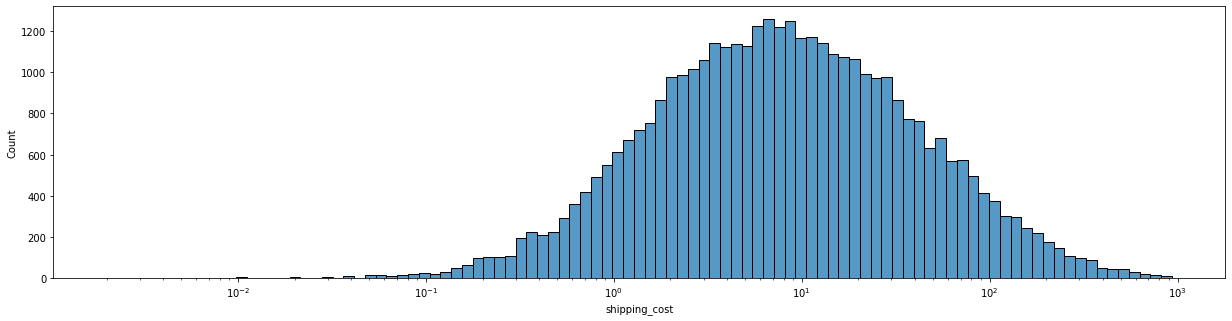

In [38]:
sns.histplot(data=df_train, x="shipping_cost", log_scale=True)

#### Order Priority

In [39]:
df_train["order_priority"].value_counts()

Medium      22087
High        11617
Critical     2927
Low          1840
Name: order_priority, dtype: int64

* OneHotEncoder or OrdinalEncoder
* Order Prio may have impact on shipment delay

#### Returned

In [40]:
df_train["returned"].value_counts()

No     36159
Yes     2312
Name: returned, dtype: int64

* 0/1, LabelBinarizer
* questionable if it makes sense

### Potential relationships

<AxesSubplot:>

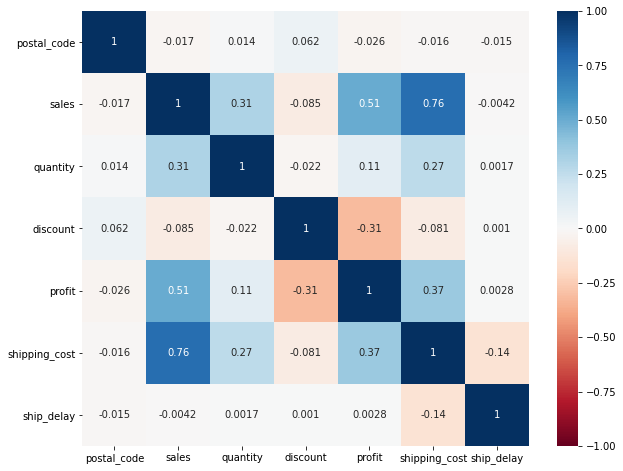

In [41]:
plt.rcParams["figure.figsize"] = [10,8]
sns.heatmap(df_train.corr(), vmin=-1, vmax=1, cmap="RdBu", annot=True)

#### Impact of order priority on ship_delay

In [42]:
pd.crosstab(df_train["ship_delay"], df_train["order_priority"])

order_priority,Critical,High,Low,Medium
ship_delay,,,,
0,563,927,0,497
1,276,640,0,328
2,1316,2605,0,1320
3,772,1436,0,1535
4,0,4376,0,6406
5,0,1633,0,6747
6,0,0,960,3794
7,0,0,880,1460


<AxesSubplot:xlabel='order_priority', ylabel='ship_delay'>

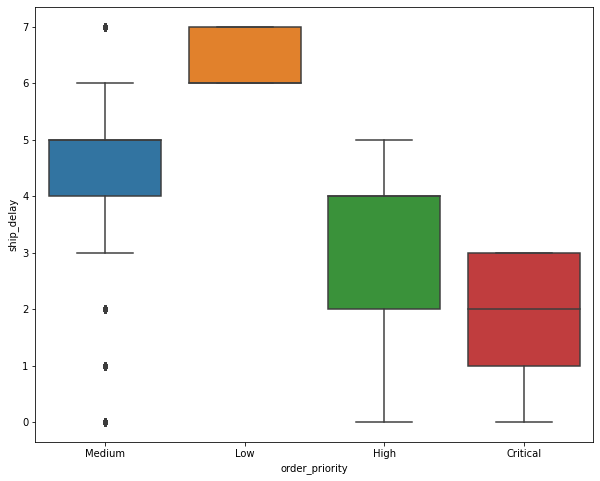

In [43]:
sns.boxplot(x="order_priority", y="ship_delay", data=df_train)

* Order Priority has a signifcant impact on the shipment delay

#### Impact of Ship Mode on ship_delay

<AxesSubplot:xlabel='ship_mode', ylabel='ship_delay'>

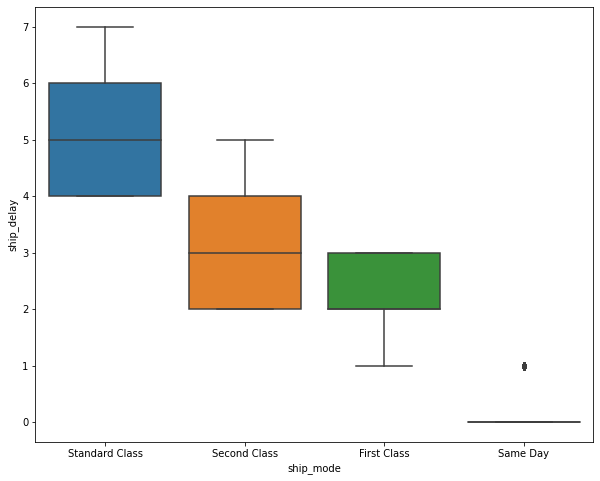

In [44]:
sns.boxplot(x="ship_mode", y="ship_delay", data=df_train)

#### Impact of quantity / sales on ship_delay

In [45]:
qty_delay = pd.crosstab(df_train["quantity"], df_train["ship_delay"], normalize='index', margins=True)

<AxesSubplot:xlabel='ship_delay', ylabel='quantity'>

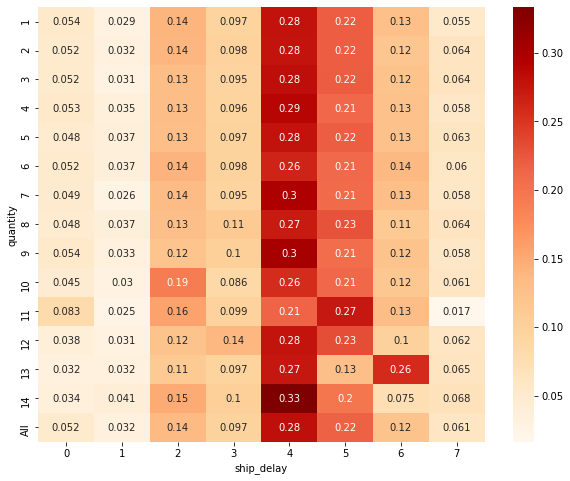

In [46]:
sns.heatmap(qty_delay, cmap="OrRd", annot=True)

In [ ]:
#qty_delay

* insignificant

In [47]:
bin_labels = [1,2,3,4,5]

df_inspect = df_train.copy()
df_inspect['sales_quantiles'] = pd.qcut(df_inspect['sales'],
                              q=5,
                              labels=bin_labels)

In [48]:
sls_delay = pd.crosstab(df_inspect["sales_quantiles"], df_inspect["ship_delay"], normalize='index', margins=True)

<AxesSubplot:xlabel='ship_delay', ylabel='sales_quantiles'>

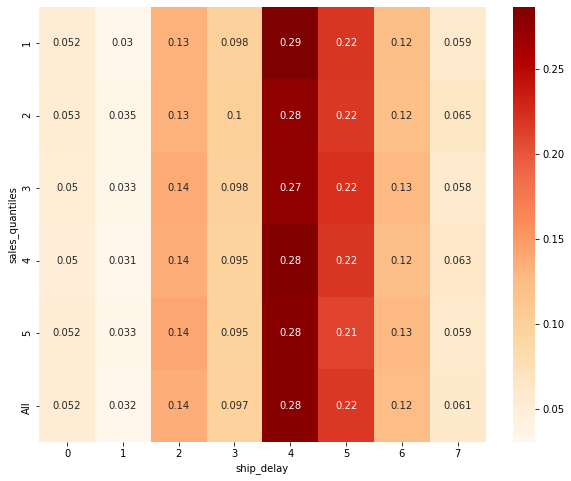

In [49]:
sns.heatmap(sls_delay, cmap="OrRd", annot=True)

* insignificant

#### Impact of profit on ship_delay

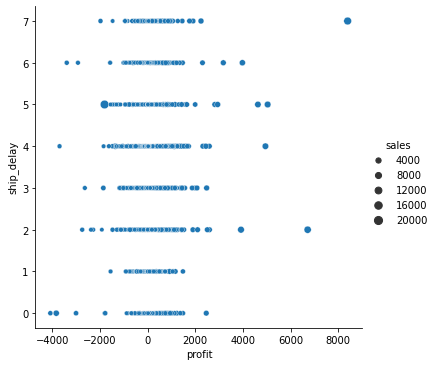

In [50]:
sns.relplot(data=df_inspect, x="profit", y="ship_delay", size="sales")

#### Profit per Sales

#### Impact of Region on ship_delay

In [51]:
region_delay = pd.crosstab(df_inspect["region"], df_inspect["ship_delay"], normalize='index', margins=True)

<AxesSubplot:xlabel='ship_delay', ylabel='region'>

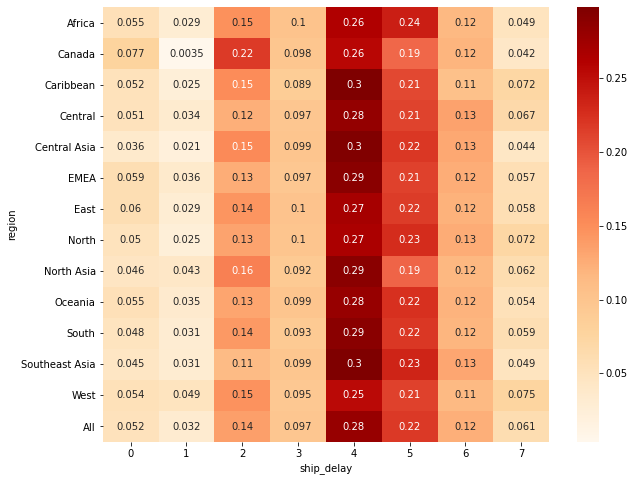

In [52]:
sns.heatmap(region_delay, cmap="OrRd", annot=True)

#### Impact of Category on ship_dely

In [53]:
subcat_delay = pd.crosstab(df_inspect["sub-category"], df_inspect["ship_delay"], normalize='index', margins=True)

<AxesSubplot:xlabel='ship_delay', ylabel='sub-category'>

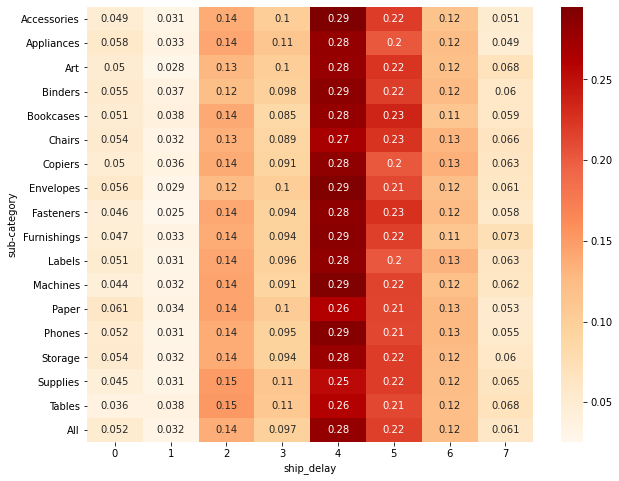

In [54]:
sns.heatmap(subcat_delay, cmap="OrRd", annot=True)

#### Impact of Order Date (resp. month) on ship_delay

<AxesSubplot:xlabel='order_month', ylabel='ship_delay'>

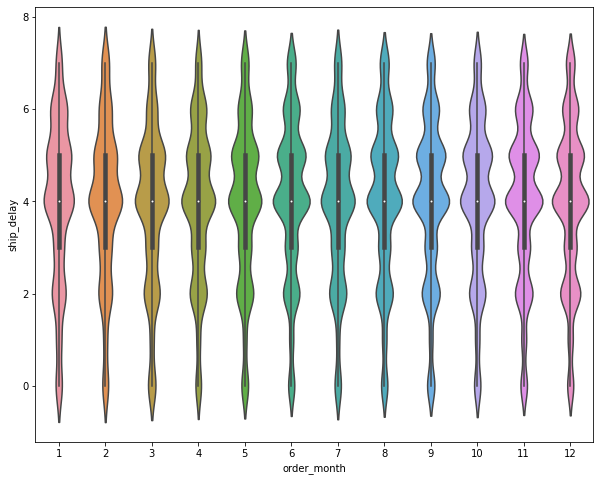

In [55]:
df_inspect['order_month'] = df_inspect.apply(lambda x: x['order_date'].month, axis=1)
sns.violinplot(data=df_inspect, x="order_month", y="ship_delay")

#### Impact of Segment on ship_delay

In [57]:
pd.crosstab(df_train["ship_delay"], df_train["segment"])

segment,Consumer,Corporate,Home Office
ship_delay,,,
0,1078,525,384
1,654,340,250
2,2761,1572,908
3,1924,1184,635
4,5605,3177,2000
5,4346,2575,1459
6,2482,1389,883
7,1169,709,462


<AxesSubplot:xlabel='segment', ylabel='ship_delay'>

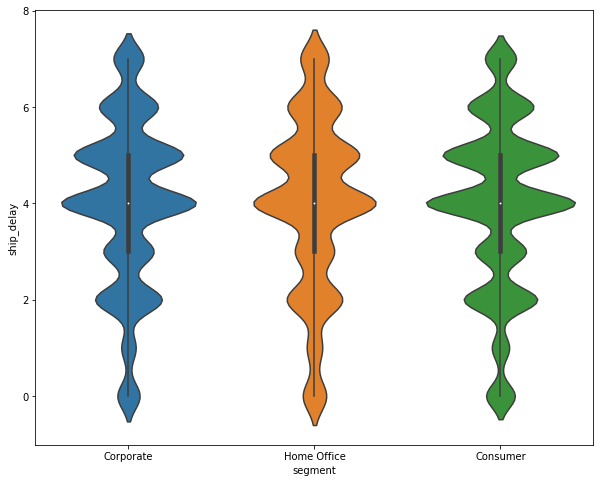

In [58]:
sns.violinplot(x="segment", y="ship_delay", data=df_train)

# Export

In [59]:
train_out = open(os.path.join("..",temp_path, pckl_train),'wb')
pickle.dump(df_train,train_out)
train_out.close()

In [60]:
test_out = open(os.path.join("..",temp_path, pckl_test),'wb')
pickle.dump(df_test,test_out)
test_out.close()